# **Imports**

In [ ]:
#!pip install --quiet torchvision scikit-learn matplotlib

# Main imports
import os
import time
import random

import torch  #main PyTorch library
import torch.nn as nn  #to define neural networks (layers, loss functions)
import torch.optim as optim  #to define optimizers (e.g., Adam, SGD)
import torchvision  #PyTorch's computer vision library
import torchvision.datasets as datasets  #to load prebuilt datasets like Food-101 and SVHN
import torchvision.transforms as transforms  #to apply image transformations/preprocessing
import torchvision.models as models  #to use pretrained models (e.g., ResNet)
from torchvision.models import resnet50
from torch.utils.data import DataLoader, random_split  #to create data loaders for batching data
from torch.amp import autocast, GradScaler
from torch.optim.swa_utils import AveragedModel, SWALR
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

# Imports for metrics and visualization
import numpy as np  #numerical operations with arrays
import matplotlib.pyplot as plt  #to plot graphs and figures
import seaborn as sns  #for data visualization
from sklearn.metrics import roc_auc_score, roc_curve , precision_recall_curve, auc  #metrics for evaluating OOD detection

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
    roc_curve,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    auc,
)


Mounted at /content/drive


# **Globals**

In [ ]:
#modifiche fatte da aldo
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(f"Using device: {device}")

Using device: cuda


# **Checkpoint define**


In [ ]:
ckpt_path = '/content/drive/MyDrive/food101_checkpoint.pth'
ckpt_new = '/content/drive/MyDrive/food101_checkpoint_new.pth'
ckpt = '/content/drive/MyDrive/cp.pth/food101_checkpoint_new .pth'
start_epoch = 0

# **Utils**

In [ ]:
#inizio modifiche aldo

mean = [0.485, 0.456 , 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    #1) Geometriche di base
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(10),

    #2) Variazione colore
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # (6)
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomPosterize(bits=4),
    transforms.RandomErasing(p=0.3),
    transforms.RandomSolarize(threshold=128, p=0.2),
    transforms.RandomAutocontrast(p=0.3),

    #3) extra
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # (5)
    transforms.RandomPerspective(distortion_scale=0.3, p=0.3),
    transforms.RandomInvert(p=0.2),
    transforms.RandAugment(num_ops=2),
    transforms.GaussianBlur(3),

    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

valid_transfomr = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # (A)
    transforms.CenterCrop(224),     # (B)
    transforms.ToTensor(),          # (C)
    transforms.Normalize(mean, std) # (D)
])

#fine modifiche aldo

# **DataSets**

In [ ]:
#import del dataset con le nuove trasform

# Dataset di training
food101_train = datasets.Food101(root='./data', split='train', download=True, transform=train_transform)

# Dataset di validation
n_val = int(0.1 * len(food101_train))
n_train = len(food101_train) - n_val
food101_train, food101_val = random_split(food101_train, [n_train, n_val])
food101_val.dataset.transform = valid_transfomr

# Dataset di test
food101_test = datasets.Food101(root='./data', split='test', download=True, transform=test_transform)

# DataLoader
train_loader = DataLoader(food101_train, batch_size=32, shuffle=True, num_workers=4 , pin_memory = True)
val_loader = DataLoader(food101_val, batch_size=32, shuffle=False, num_workers=4 , pin_memory = True)
test_loader = DataLoader(food101_test, batch_size=32, shuffle=False, num_workers=4 , pin_memory = True)

#!pip install lmdb
#from torchvision.datasets import ImageFolder
#import lmdb

#Dataser CIFAR100
ood_test_data = datasets.CIFAR100(root='./data', train = False, download = True, transform=test_transform)
ood_test_loader = DataLoader(ood_test_data, batch_size=64, shuffle=False, num_workers = 4, pin_memory = True)

# Dataset SVHN
ood_train_data = datasets.SVHN(root='./data', split='train', download=True, transform=test_transform)
ood_train_loader = DataLoader(ood_train_data, batch_size=64, shuffle=False , num_workers = 4, pin_memory = True)

torch.backends.cudnn.benchmark = True

#fine


100%|██████████| 5.00G/5.00G [04:25<00:00, 18.8MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 169M/169M [00:13<00:00, 12.4MB/s]
100%|██████████| 182M/182M [00:21<00:00, 8.53MB/s]


In [ ]:
img_tensor, label = ood_data[26000]  # immagine e etichetta

# Inverti normalizzazione
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
img = inv_normalize(img_tensor).clamp(0, 1)

# Visualizza
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


# **Network**

In [ ]:
model = resnet50(pretrained=True)

for p in model.parameters():
    p.requires_grad = False

for p in model.layer2.parameters():
    p.requires_grad = True

for p in model.layer3.parameters():
    p.requires_grad = True

for p in model.layer4.parameters():
    p.requires_grad = True

for p in model.fc.parameters():
    p.requires_grad = True

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 101)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)

optimizer = optim.AdamW([
    {'params': model.layer4.parameters(), 'lr': 7e-5},
    {'params': model.fc.parameters(), 'lr': 3e-4},
    {'params': model.layer3.parameters(), 'lr': 5e-5},
    {'params': model.layer2.parameters(), 'lr': 3e-5}
], weight_decay=2e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=[7e-5,3e-4,5e-5,3e-5], steps_per_epoch=len(train_loader), epochs = 10)

swa_start    = 20
swa_model    = AveragedModel(model)
swa_scheduler = SWALR(optimizer, swa_lr=1e-5)

scaler = GradScaler()




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]


# **checkpoint new**

In [ ]:
#files.upload('/content/drive/MyDrive/point.pth')

Saving food101_checkpoint_new .pth to /content/drive/MyDrive/cp.pth/food101_checkpoint_new .pth
Buffered data was truncated after reaching the output size limit.

In [ ]:
if os.path.exists(ckpt):
    print("Loading checkpoint...")
    ckpt = torch.load(ckpt, map_location=device)
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['optim_state'])
    scheduler.load_state_dict(ckpt['sched_state'])
    start_epoch = ckpt['epoch'] + 1
    print(f"Resuming from epoch {start_epoch}")

Loading checkpoint...
Resuming from epoch 52



# **Checkpoint setup**



In [ ]:
if os.path.exists(ckpt_path):
    print("Loading checkpoint...")
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['optim_state'])
    scheduler.load_state_dict(ckpt['sched_state'])
    start_epoch = ckpt['epoch'] + 1
    print(f"Resuming from epoch {start_epoch}")



Loading checkpoint...
Resuming from epoch 45


# **Sblocco e nuovi parametri**

In [ ]:
for p in model.layer1.parameters():
    p.requires_grad = True

optimizer = optim.AdamW([
    {'params': model.layer1.parameters(), 'lr': 0.5e-6},
    {'params': model.layer2.parameters(), 'lr': 1.5e-5},
    {'params': model.layer3.parameters(), 'lr': 2.5e-5},
    {'params': model.layer4.parameters(), 'lr': 3.5e-5},
    {'params': model.fc.parameters(),   'lr': 1.5e-4},
], weight_decay=2e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=[0.5e-6,1.5e-5,2.5e-5,3.5e-5,1.5e-4], steps_per_epoch=len(train_loader), epochs = 3)

# **Analisi layer**

In [ ]:
num_frozen = 0
num_trainable = 0

for name, param in model.named_parameters():
    if not param.requires_grad:
        num_frozen += 1
    else:
        num_trainable += 1

    status = "frozen" if not param.requires_grad else "trainable"

    print(f"Parametri congelati (requires_grad=False):   {num_frozen}")
    print(f"Parametri addestrabili (requires_grad=True): {num_trainable}")
    print(f"{name:40s} → {status}")

Parametri congelati (requires_grad=False):   1
Parametri addestrabili (requires_grad=True): 0
conv1.weight                             → frozen
Parametri congelati (requires_grad=False):   2
Parametri addestrabili (requires_grad=True): 0
bn1.weight                               → frozen
Parametri congelati (requires_grad=False):   3
Parametri addestrabili (requires_grad=True): 0
bn1.bias                                 → frozen
Parametri congelati (requires_grad=False):   4
Parametri addestrabili (requires_grad=True): 0
layer1.0.conv1.weight                    → frozen
Parametri congelati (requires_grad=False):   5
Parametri addestrabili (requires_grad=True): 0
layer1.0.bn1.weight                      → frozen
Parametri congelati (requires_grad=False):   6
Parametri addestrabili (requires_grad=True): 0
layer1.0.bn1.bias                        → frozen
Parametri congelati (requires_grad=False):   7
Parametri addestrabili (requires_grad=True): 0
layer1.0.conv2.weight                    →

# **Analisi Pesi**

In [ ]:
from collections import defaultdict

stats = defaultdict(lambda: { "count":0,
                              "sum_l2":0.0, "sum_mean":0.0, "sum_std":0.0,
                              "mins":[], "maxs":[] })

# Itera solo sui tensori di tipo weight
for name, param in model.named_parameters():
    if "weight" not in name:
        continue

    # Immaginiamo che i nomi siano del tipo "layer2.3.conv1.weight"
    # e vogliamo estrarre "layer2" come chiave di raggruppamento:
    layer_block = name.split('.')[0]  # estrae "layer2", o "conv1", o "bn1", o "fc"

    w = param.data
    l2_norm = torch.norm(w).item()
    mean_val = w.mean().item()
    std_val  = w.std().item()
    min_val  = w.min().item()
    max_val  = w.max().item()

    stats[layer_block]["count"] += 1
    stats[layer_block]["sum_l2"]  += l2_norm
    stats[layer_block]["sum_mean"]+= mean_val
    stats[layer_block]["sum_std"] += std_val
    stats[layer_block]["mins"].append(min_val)
    stats[layer_block]["maxs"].append(max_val)

print("STATISTICHE AGGREGATE PER BLOCCO:\n")
for block, d in stats.items():
    cnt = d["count"]
    avg_l2  = d["sum_l2"] / cnt
    avg_mean= d["sum_mean"] / cnt
    avg_std = d["sum_std"] / cnt
    block_min = min(d["mins"])
    block_max = max(d["maxs"])

    print(f"{block:10s} | #tensori: {cnt:2d} | L2_norm_avg: {avg_l2:6.3f} | mean_avg: {avg_mean:6.3f} | std_avg: {avg_std:6.3f} | min_all: {block_min:6.3f} | max_all: {block_max:6.3f}")


STATISTICHE AGGREGATE PER BLOCCO:

conv1      | #tensori:  1 | L2_norm_avg: 11.951 | mean_avg: -0.000 | std_avg:  0.123 | min_all: -0.782 | max_all:  0.781
bn1        | #tensori:  1 | L2_norm_avg:  2.170 | mean_avg:  0.257 | std_avg:  0.086 | min_all:  0.000 | max_all:  0.508
layer1     | #tensori: 20 | L2_norm_avg:  3.443 | mean_avg:  0.080 | std_avg:  0.053 | min_all: -0.744 | max_all:  0.988
layer2     | #tensori: 26 | L2_norm_avg:  4.643 | mean_avg:  0.073 | std_avg:  0.037 | min_all: -0.340 | max_all:  0.566
layer3     | #tensori: 38 | L2_norm_avg:  6.833 | mean_avg:  0.075 | std_avg:  0.028 | min_all: -0.497 | max_all:  0.525
layer4     | #tensori: 20 | L2_norm_avg: 13.671 | mean_avg:  0.147 | std_avg:  0.033 | min_all: -0.454 | max_all:  1.320
fc         | #tensori:  1 | L2_norm_avg:  5.804 | mean_avg: -0.000 | std_avg:  0.013 | min_all: -0.022 | max_all:  0.022


# **Analisi LR**


In [ ]:
print("ELENCO PARAMETRI E LR ASSOCIATO:\n")
for name, param in model.named_parameters():
    if not param.requires_grad:
        # layer/filtro congelato: non ha LR (o, tecnicamente, il gradient non viene calcolato)
        print(f"{name:40s} → frozen (requires_grad=False)")
        continue

    # Cerchiamo a quale param_group questo parametro appartiene
    lr_of_this_param = None
    for pg in optimizer.param_groups:
        # “pg['params']” è una lista di tensori: se questo tensore (param) è in quella lista,
        # allora appartiene a quel gruppo, e il suo lr è pg['lr'].
        if any(param is p for p in pg['params']):
            lr_of_this_param = pg['lr']
            break

    if lr_of_this_param is None:
        # > Se capita che param non appaia in nessun param_group, significa che non è
        #   passato all’optimizer (ad esempio era già frozen).
        print(f"{name:40s} → (NON gestito dall’optimizer)")
    else:
        print(f"{name:40s} → lr = {lr_of_this_param:.1e}")

ELENCO PARAMETRI E LR ASSOCIATO:

conv1.weight                             → frozen (requires_grad=False)
bn1.weight                               → frozen (requires_grad=False)
bn1.bias                                 → frozen (requires_grad=False)
layer1.0.conv1.weight                    → frozen (requires_grad=False)
layer1.0.bn1.weight                      → frozen (requires_grad=False)
layer1.0.bn1.bias                        → frozen (requires_grad=False)
layer1.0.conv2.weight                    → frozen (requires_grad=False)
layer1.0.bn2.weight                      → frozen (requires_grad=False)
layer1.0.bn2.bias                        → frozen (requires_grad=False)
layer1.0.conv3.weight                    → frozen (requires_grad=False)
layer1.0.bn3.weight                      → frozen (requires_grad=False)
layer1.0.bn3.bias                        → frozen (requires_grad=False)
layer1.0.downsample.0.weight             → frozen (requires_grad=False)
layer1.0.downsample.1.weight  

# **Train**

In [ ]:
# Allenamento su pochi batch per demo
#model.train()
#for i, (images, labels) in enumerate(train_loader):
#    images, labels = images.to(device), labels.to(device)
#    optimizer.zero_grad()
#    outputs = model(images)
#    loss = criterion(outputs, labels)
#    loss.backward()
#    optimizer.step()

#    if i == 10:  # 👈 cambia o rimuovi per fare training completo
#        break

# Training loop
#num_epochs = 10
num_epochs = 53
patience, wait = 5, 0
best_id_acc = 0.0
for epoch in range(start_epoch,num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        with autocast(device_type = 'cuda' ):
          outputs = model(images)
          loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        #loss.backward()
        #optimizer.step()
        running_loss += loss.item()

    scheduler.step()

    if epoch >= swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()

    avg_loss = running_loss / len(train_loader)
    elapsed = time.time() - start_time

    # Validate in-distribution accuracy
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type = 'cuda'):
                preds = model(images).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    id_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} loss: {running_loss/len(train_loader):.4f} — "
          f"ID Acc: {id_acc:.2f}% — time: {elapsed:.1f}s")


    #torch.save({
       # 'epoch': epoch,
       # 'model_state': model.state_dict(),
      #  'optim_state' : optimizer.state_dict(),
     #   'sched_state' : scheduler.state_dict()
    #}, ckpt_path)

    if id_acc > best_id_acc:
        best_id_acc = id_acc
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

if num_epochs > swa_start:
    torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)


Epoch 53/53 loss: 0.9045 — ID Acc: 99.99% — time: 388.4s


KeyboardInterrupt: 

# **Train odd-exposure**

In [ ]:
# ─── DICHIARAZIONI PRELIMINARI ────────────────────────────────────────────────────
# (import già fatti; definiamo solo le nuove funzioni / loader)
def compute_energy(logits, T=1):
    # free energy score
    return -T * torch.logsumexp(logits / T, dim=1)

def mixup_data(x, y, alpha=0.2):
  lam = np.random.beta(alpha, alpha)
  idx = torch.randperm(x.size(0))
  mixed_x = lam*x + (1-lam)*x[idx, :]
  y_a, y_b = y, y[idx]
  return mixed_x, y_a, y_b, lam

# supponiamo tu abbia già:
#   train_loader  -> Food-101 train
#   ood_train_loader -> SVHN train (o un campione di TinyImages)
#   val_loader    -> Food-101 valid
#   model, optimizer, scheduler, scaler, ckpt_path, start_epoch, ...
λ = 0.1                # peso della regularization energy
margin_id  = -5      # energia massima ammessa sugli ID
margin_ood = -15     # energia minima ammessa sugli OOD

ood_iter = iter(ood_train_loader)  # itero SVHN come “OOD exposure”

# ─── TRAINING CON ENERGY-BASED OOD EXPOSURE ────────────────────────────────────
best_val_acc = 0.0
best_val_auroc = 0.0
patience = 3
wait_acc = wait_auroc = 0

for epoch in range(start_epoch, 46):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # 1) prendi un batch di OOD; riaziona iterator
        try:
            ood_imgs, _ = next(ood_iter)
        except StopIteration:
            ood_iter = iter(ood_train_loader)
            ood_imgs, _ = next(ood_iter)

        images, labels = images.to(device), labels.to(device)
        ood_imgs = ood_imgs.to(device)

        optimizer.zero_grad()
        with autocast(device_type = 'cuda'):
            logits_id  = model(images)
            logits_ood = model(ood_imgs)
            # cross-entropy sulle ID
            ce_loss = criterion(logits_id, labels)
            # energy
            E_id  = compute_energy(logits_id)
            E_ood = compute_energy(logits_ood)
            # hinge‐loss quadratica sugli ID e sugli OOD
            loss_id  = torch.mean(torch.relu( E_id  - margin_id )**2)
            loss_ood = torch.mean(torch.relu( margin_ood - E_ood )**2)
            loss_energy = loss_id + loss_ood
            # loss totale
            loss = ce_loss + λ * loss_energy

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    scheduler.step()
    if epoch>=swa_start:
        swa_model.update_parameters(model); swa_scheduler.step()

    # ─── VALIDATION ─────────────────────────────────
    model.eval()
    correct = total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type = 'cuda'):
                logits = model(images)
                val_loss += criterion(logits, labels).item()
                preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc  = 100 * correct / total

    id_val_scores, ood_val_scores = [], []
    with torch.no_grad():
        # ID energies
        for images, _ in val_loader:
            images = images.to(device)
            id_val_scores.extend(compute_energy(model(images)).cpu().numpy())
        # OOD energies
        for images, _ in ood_test_loader:
            images = images.to(device)
            ood_val_scores.extend(compute_energy(model(images)).cpu().numpy())

    labels_val = np.concatenate([np.zeros(len(id_val_scores)), np.ones(len(ood_val_scores))])
    scores_val = np.concatenate([id_val_scores, ood_val_scores])
    val_auroc = roc_auc_score(labels_val, scores_val)

    print(f"Epoch {epoch+1}/{46} — "
          f"TrainL={running_loss/len(train_loader):.4f} — "
          f"ValL={val_loss:.4f} — ValAcc={val_acc:.2f}% valAUROC={val_auroc:.4f}")

    # salva checkpoint
    torch.save({
        'epoch': epoch,
        'model_state':   model.state_dict(),
        'optim_state':   optimizer.state_dict(),
        'sched_state':   scheduler.state_dict(),
        'scaler_state':  scaler.state_dict(),
    }, ckpt_new)

    improved = False
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait_acc = 0
        improved = True
    else:
        wait_acc += 1

    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        wait_auroc = 0
        improved = True
    else:
        wait_auroc += 1

    if not improved and (wait_acc >= patience or wait_auroc >= patience):
        print("Early stopping triggered")
        break

/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


# **Test**

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



AUROC (Energy OOD): 0.7837
Threshold (95% ID): -4.80

=== Classification Report ===
              precision    recall  f1-score   support

          ID       0.73      0.95      0.83     25250
         OOD       0.49      0.12      0.19     10000

    accuracy                           0.71     35250
   macro avg       0.61      0.54      0.51     35250
weighted avg       0.66      0.71      0.65     35250


=== Confusion Matrix ===
[[23987  1263]
 [ 8784  1216]]
Accuracy : 71.50%
Precision: 49.05%
Recall   : 12.16%
F1 (binary): 0.1949
F1 per classe: ID=0.8268, OOD=0.1949

FPR: 5.00%, TPR: 87.84%
————— Energy-based OOD Metrics —————
AUROC:        0.7837
AUPR:         0.4871
FPR@95% TPR:  51.32%  (soglia → tpr≥95%)
Threshold (95° percentile ID): -4.8002
FPR emp:      5.00%  (ID fuori soglia)
 False Positives (ID classificati come OOD): 1263 su 25250
TPR emp:      87.84%  (OOD sopra soglia)
 True Positives (OOD rilevati correttamente): 8784 su 10000


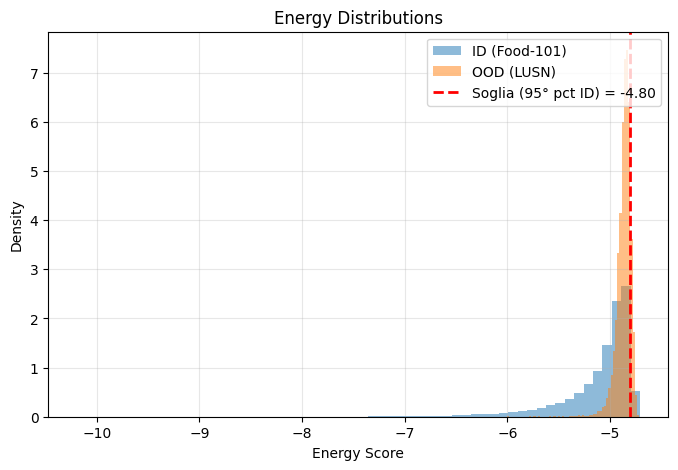

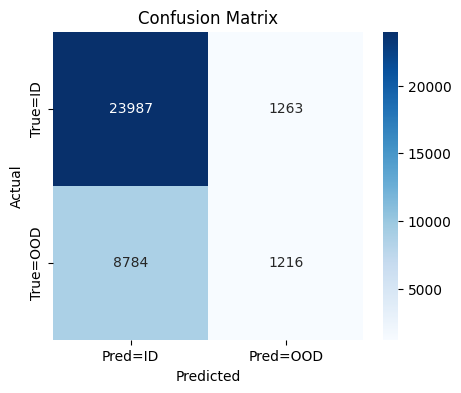

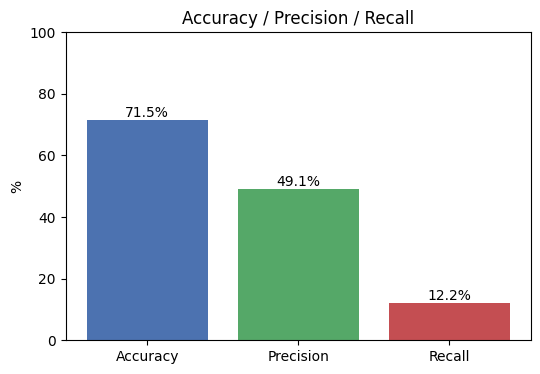

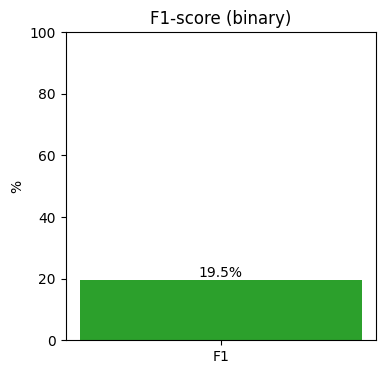

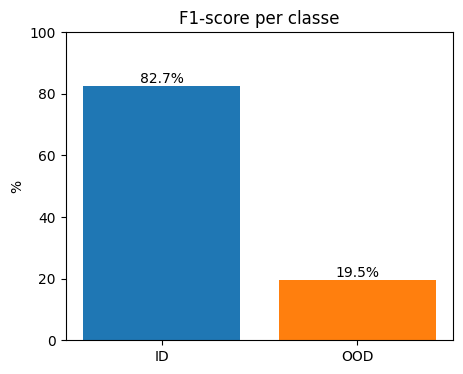

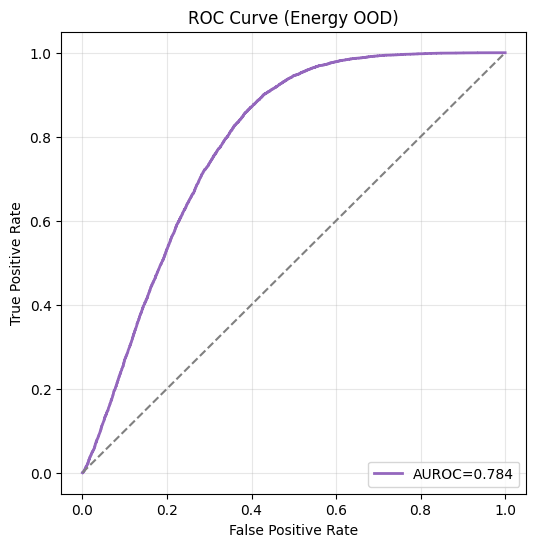

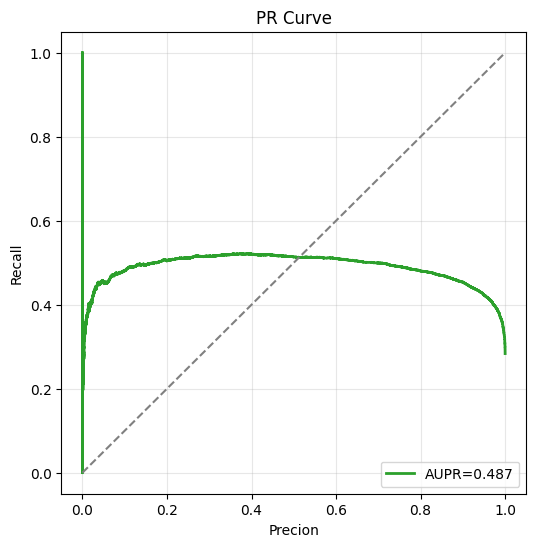

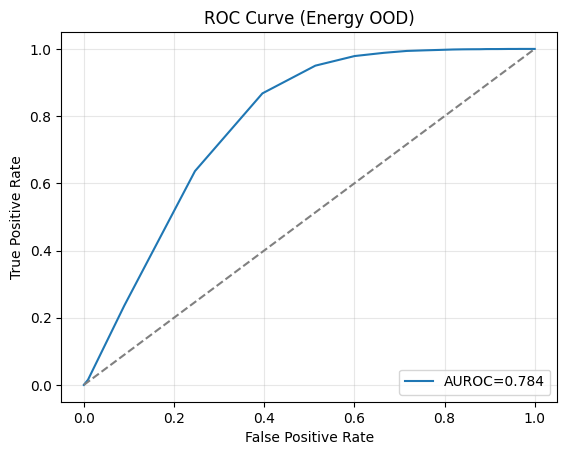

In [ ]:

def compute_energy(logits, T=1):
    return -T * torch.logsumexp(logits / T, dim=1)

model.eval()
id_energies, ood_energies = [], []

with torch.no_grad():
    for images, _ in test_loader:      # test_loader è il tuo DataLoader di Food-101 “test”
        images = images.to(device)
        logits = model(images)
        e = compute_energy(logits)     # shape: (batch_size,)
        id_energies.extend(e.cpu().numpy())

with torch.no_grad():
    for images, _ in ood_test_loader:
        images = images.to(device)
        logits = model(images)
        e = compute_energy(logits)
        ood_energies.extend(e.cpu().numpy())

id_energies = np.array(id_energies)
ood_energies = np.array(ood_energies)


# Scores for ROC/AUROC
all_scores = np.concatenate([id_energies, ood_energies])
all_labels = np.concatenate([np.zeros(len(id_energies),  dtype=int), np.ones(len(ood_energies), dtype=int),])

# Threshold at 95th percentile of ID energies
threshold = np.percentile(id_energies, 95)

# Predizioni binarie: 1 = considerato OOD (energy > thr)
preds = (all_scores > threshold).astype(int)

# —── 3) Matrice di confusione
cm = confusion_matrix(all_labels, preds)


# —── 4) Accuracy, Precision, Recall
acc   = accuracy_score(all_labels, preds)
prec  = precision_score(all_labels, preds)
rec   = recall_score(all_labels, preds)

metrics = {
    "Accuracy": accuracy_score(all_labels, preds),
    "Precision": precision_score(all_labels,preds),
    "Recall": recall_score(all_labels,preds)
}

f1 = f1_score(all_labels, preds)
f1_per_class = f1_score(all_labels, preds, average=None)

# AUROC e ROC curve
fpr_arr, tpr_arr, roc_thresholds = roc_curve(all_labels, all_scores)
roc_auc       = auc(fpr_arr, tpr_arr)
auroc = roc_auc_score(all_labels, all_scores)


#stampe varie
print(f"\nAUROC (Energy OOD): {auroc:.4f}")
print(f"Threshold (95% ID): {threshold:.2f}")
print("\n=== Classification Report ===")
print(classification_report(all_labels, preds, target_names=['ID','OOD']))
print("\n=== Confusion Matrix ===")
print(cm)
print(f"Accuracy : {acc*100:5.2f}%")
print(f"Precision: {prec*100:5.2f}%")
print(f"Recall   : {rec*100:5.2f}%")
print(f"F1 (binary): {f1:.4f}")
print(f"F1 per classe: ID={f1_per_class[0]:.4f}, OOD={f1_per_class[1]:.4f}")
print()

#Calcolo Precision-Recall Curve e AUPR
precisions, recalls, _ = precision_recall_curve(all_labels, all_scores)
aupr = auc(recalls, precisions)

# 7) FPR@95% TPR:
#    Troviamo il primo indice i tale che tpr_arr[i] >= 0.95, poi fpr_arr[i]
idx95 = np.argmax(tpr_arr >= 0.95)
fpr95 = fpr_arr[idx95] if idx95 < len(fpr_arr) else 1.0


# FPR / TPR
id_fp   = (np.array(id_energies)  > threshold).sum()
ood_tp  = (np.array(ood_energies) < threshold).sum()
false_positives = id_fp.sum()
true_positives = ood_tp.sum()
fpr_emp = id_fp  / len(id_energies)
tpr_emp = ood_tp / len(ood_energies)
print(f"FPR: {fpr_emp*100:.2f}%, TPR: {tpr_emp*100:.2f}%")


print("————— Energy-based OOD Metrics —————")
print(f"AUROC:        {auroc:.4f}")
print(f"AUPR:         {aupr:.4f}")
print(f"FPR@95% TPR:  {fpr95*100:.2f}%  (soglia → tpr≥95%)")
print(f"Threshold (95° percentile ID): {threshold:.4f}")
print(f"FPR emp:      {fpr_emp*100:.2f}%  (ID fuori soglia)")
print(f" False Positives (ID classificati come OOD): {false_positives} su {len(id_energies)}")
print(f"TPR emp:      {tpr_emp*100:.2f}%  (OOD sopra soglia)")
print(f" True Positives (OOD rilevati correttamente): {true_positives} su {len(ood_energies)}")


# ─── 8. PLOTS ────────────────────────────────────────────────────────────────────
# Histograms
plt.figure(figsize=(8,5))
plt.hist(id_energies,  bins=60, density = True, alpha=0.5, label='ID (Food-101)', color = 'tab:blue')
plt.hist(ood_energies, bins=60, density = True, alpha=0.5, label='OOD (LUSN)', color = 'tab:orange')
plt.axvline(threshold, color='red', linestyle='--', linewidth= 2, label=f"Soglia (95° pct ID) = {threshold:.2f}")
plt.xlabel("Energy Score")
plt.ylabel("Density")
plt.legend(loc='upper right')
plt.title("Energy Distributions")
plt.grid(alpha=0.3)
plt.show()

# 3b) Heatmap della confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred=ID','Pred=OOD'],
            yticklabels=['True=ID','True=OOD'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Bar chart di accuracy, PRecision , Recall
plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), [v*100 for v in metrics.values()], color=["#4C72B0","#55A868","#C44E52"])
plt.ylim(0,100)
for i,(k,v) in enumerate(metrics.items()):
    plt.text(i, v*100 + 1, f"{v*100:4.1f}%", ha="center")
plt.title("Accuracy / Precision / Recall")
plt.ylabel("%")
plt.show()


# 2) plot globale di f1
plt.figure(figsize=(4,4))
plt.bar(["F1"], [f1*100], color="tab:green")
plt.ylim(0,100)
plt.title("F1-score (binary)")
plt.ylabel("%")
plt.text(0, f1*100+1, f"{f1*100:.1f}%", ha="center")
plt.show()

# 3) plot per classe di f1
labels = ["ID","OOD"]
plt.figure(figsize=(5,4))
plt.bar(labels, [v*100 for v in f1_per_class], color=["tab:blue","tab:orange"])
plt.ylim(0,100)
for i,v in enumerate(f1_per_class):
    plt.text(i, v*100+1, f"{v*100:.1f}%", ha="center")
plt.title("F1-score per classe")
plt.ylabel("%")
plt.show()

#ROC Curve con fpr_arr, tpr_arr
plt.figure(figsize=(6,6))
plt.plot(fpr_arr, tpr_arr, color= 'tab:purple', lw=2,  label=f"AUROC={auroc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Energy OOD)")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# PR Curve
plt.figure(figsize=(6,6))
plt.plot(recalls, precisions, color= 'tab:green', lw=2,  label=f"AUPR={aupr:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("Precion")
plt.ylabel("Recall")
plt.title("PR Curve")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


scores = all_scores
labels = all_labels

# 100 soglie uniformi
threshs = np.linspace(scores.min(), scores.max(), 100)
fpr_list, tpr_list = [], []

for t in threshs:
    preds = (scores > t).astype(int)
    TP = ((preds==1)&(labels==1)).sum()
    FP = ((preds==1)&(labels==0)).sum()
    P  = (labels==1).sum()
    N  = (labels==0).sum()
    tpr_list.append(TP/P)
    fpr_list.append(FP/N)

# poi plot:
plt.plot(fpr_list, tpr_list, label=f"AUROC={roc_auc_score(labels, scores):.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Energy OOD)")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()